In [30]:
%matplotlib inline

# NLP FROM SCRATCH: GENERATING NAMES WITH A CHARACTER-LEVEL RNN

This is our second of three tutorials on “NLP From Scratch”. In the first tutorial </intermediate/char_rnn_classification_tutorial> we used a RNN to classify names into their language of origin. This time we’ll turn around and generate names from languages.

We are still hand-crafting a small RNN with a few linear layers. The big difference is instead of predicting a category after reading in all the letters of a name, we input a category and output one letter at a time. Recurrently predicting characters to form language (this could also be done with words or other higher order constructs) is often referred to as a “language model”.

## Preparing the Data

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


In [28]:
category_lines['Korean'][:10]

['Ahn', 'Baik', 'Bang', 'Byon', 'Cha', 'Chang', 'Chi', 'Chin', 'Cho', 'Choe']

In [2]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'-"

## Creating the Network

This network extends the last tutorial’s RNN with an extra argument for the category tensor, which is concatenated along with the others. The category tensor is a one-hot vector just like the letter input.

We will interpret the output as the probability of the next letter. When sampling, the most likely output letter is used as the next input letter.

I added a second linear layer o2o (after combining hidden and output) to give it more muscle to work with. There’s also a dropout layer, which randomly zeros parts of its input with a given probability (here 0.1) and is usually used to fuzz inputs to prevent overfitting. Here we’re using it towards the end of the network to purposely add some chaos and increase sampling variety.

<img src='https://i.imgur.com/jzVrf7f.png'>

In [3]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size , hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size , output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## Training

## Preparing for Training

First of all, helper functions to get random pairs of (category, line):

In [4]:
import random

# 리스트에서 랜덤 추출
def randomChoice(l):
    return l[random.randint(0, len(l) -1)]

# 랜덤 카테고리를 받아서 랜덤 라인을 추출
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

For each timestep (that is, for each letter in a training word) the inputs of the network will be `(category, current letter, hidden state)` and the outputs will be (next letter, next hidden state). So for each training set, we’ll need the category, a set of input letters, and a set of output/target letters.

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for "ABCD<EOS>" we would create (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”).
    
<img src='https://i.imgur.com/JH58tXY.png'>

The category tensor is a one-hot tensor of size <1 x n_categories>. When training we feed it to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.

In [5]:
all_categories.index('Korean')

11

In [6]:
'Korean'.find('KISS')

-1

In [7]:
# 카테고리를 원핫 벡터로 표현
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# 첫글자부터 마지막 글자까지를 나타낸 행렬
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# 두번째 글자의 롱텐서
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [8]:
inputTensor('Kiss')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

In [9]:
targetTensor('Kiss'),targetTensor('Kiss').unsqueeze(-1)

(tensor([ 8, 18, 18, 58]), tensor([[ 8],
         [18],
         [18],
         [58]]))

For convenience during training we’ll make a `randomTrainingExample` function that fetches a random (category, line) pair and turns them into the required (category, input, target) tensors.

In [10]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    output_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, output_line_tensor

## Training the Network

In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

The magic of autograd allows you to simply sum these losses at each step and call backward at the end.

In [11]:
criterion = nn.NLLLoss()

learning_rate = 0.01

In [12]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss+=l
        
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a `timeSince(timestamp)` function which returns a human readable string:

In [13]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a few minutes, printing the current time and loss every `print_every` examples, and keeping store of an average loss per `plot_every` examples in `all_losses` for plotting later.

In [14]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 21s (5000 5%) 1.7453
0m 43s (10000 10%) 3.0002
1m 5s (15000 15%) 2.9876
1m 26s (20000 20%) 3.1176
1m 48s (25000 25%) 2.4928
2m 10s (30000 30%) 0.7480
2m 32s (35000 35%) 1.9753
2m 54s (40000 40%) 3.2106
3m 16s (45000 45%) 2.3031
3m 38s (50000 50%) 2.6914
4m 0s (55000 55%) 1.4639
4m 22s (60000 60%) 2.3431
4m 45s (65000 65%) 2.8285
5m 6s (70000 70%) 2.4215
5m 28s (75000 75%) 1.9097
5m 50s (80000 80%) 2.6927
6m 11s (85000 85%) 2.3341
6m 33s (90000 90%) 2.8377
6m 54s (95000 95%) 1.3147
7m 16s (100000 100%) 1.9496


## Plotting the Losses

Plotting the historical loss from all_losses shows the network learning:

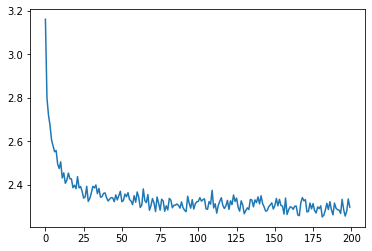

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Sampling the Network

To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.

* Create tensors for input category, starting letter, and empty hidden state
* Create a string output_name with the starting letter
* Up to a maximum output length,
    * Feed the current letter to the network
    * Get the next letter from highest output, and next hidden state
    * If the letter is EOS, stop here
    * If a regular letter, add to output_name and continue
* Return the final name

In [16]:
max_length = 20

# 샘플링 과정
def sample(category, start_letter='A'):
    with torch.no_grad(): # 샘플링 과정이니까
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter
        
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters -1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
                
            input = inputTensor(letter)
            
        return output_name

In [17]:
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [19]:
samples('Korean', 'LKP')

Ly
Kwong
Pang


In [21]:
samples('English', 'MST')

Macher
Scherel
Tracher


In [22]:
samples('Spanish', 'SPA')

Saneran
Peraner
Alamare


In [23]:
samples('Chinese', 'CHI')

Cha
Han
Iwa


## Exercises

* Try with a different dataset of category -> line, for example:
    * Fictional series -> Character name
    * Part of speech -> Word
    * Country -> City
* Use a “start of sentence” token so that sampling can be done without choosing a start letter
* Get better results with a bigger and/or better shaped network
    * Try the nn.LSTM and nn.GRU layers
    * Combine multiple of these RNNs as a higher level network